In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression
from scipy.signal import bessel, sosfiltfilt
from sklearn.cluster import KMeans

from sklearn.neighbors import KernelDensity
from data_manager import DataManager
import transport_signal_processing as tsp

In [10]:
def normalized_histogram(cores, num_bins, limits):
    # compute normalized histograms
    h_l = []
    for c in tqdm(cores):
        n, x = np.histogram(c, bins=num_bins, range=limits)
        h_l.append(n / np.sum(n))

    # compute mean noramlized histogram
    h = np.mean(np.array(h_l), axis=0)
    xc = 0.5*(x[:-1] + x[1:])
    #dx = x[1] - x[0]
    
    return h, xc

def interweave(a, b):
    c = np.empty((a.shape[0]+b.shape[0], a.shape[1]), dtype=a.dtype)
    c[0::2] = a
    c[1::2] = b
    return c

In [13]:
# parameters
# voltages: 80, 100, 120, 150, 170, 190
path = "*"
re_sel = "AA00300AA"
key = "voltage"
level = 1
selected_only = True

# setup database connector
sigman = DataManager('database')

# load segments informations
sinfo_l = sigman.load_info(path, 's*')

# convert info to dataframe
df = pd.DataFrame(sinfo_l)

# keep only selected polymers in dataframe and signal info
df = df[df['analyte'].str.match(re_sel) & (df['selected'] > (level-1))]
sinfo_l = [sinfo_l[i] for i in df.index.values]
df = df.reset_index(drop=True)

# debug print
key_names = np.unique(df[key].values)
key_names = np.array(sorted(key_names.astype(int))).astype(np.str)  # numerical value only
print(key_names.shape[0], list(key_names))
display(df)

# check
#assert len(polymer_names) == 1

3 ['80', '100', '120']


,pore,temperature,voltage,analyte,buffer,channel,id,sid,segment_range,segment_duration,MODIFIED,mI_open,sI_open,N_events,N_cores,N_reduced,selected,ratio_sel
0,K238A,25,100,AA00300AA,LiCl,4,1-0,0,"[0, 4246287]",42.46287,2022-03-10_09:58:55,44.726295,3.441116,2176.0,1001.0,1001.0,1.0,0.825175
1,K238A,25,100,AA00300AA,LiCl,4,2-0,0,"[0, 5121195]",51.21195,2022-03-10_09:58:43,43.902667,3.574460,2219.0,1075.0,1075.0,1.0,0.817674
2,K238A,25,100,AA00300AA,LiCl,4,2-0,1,"[5185984, 8182573]",29.96589,2022-03-10_09:58:43,44.055105,3.615654,1333.0,647.0,647.0,1.0,0.799073
3,K238A,25,100,AA00300AA,LiCl,4,2-0,2,"[8434663, 15932687]",74.98024,2022-03-10_09:58:55,43.880660,3.592745,3801.0,1799.0,1799.0,1.0,0.831017
4,K238A,25,100,AA00300AA,LiCl,2,3-0,4,"[25490928, 37941599]",124.50671,2022-03-10_09:58:43,41.274651,3.066304,4435.0,2356.0,2356.0,1.0,0.938455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,K238A,15,100,AA00300AA,KCl,4,6,0,"[0, 18476959]",184.76959,2022-03-10_09:58:39,67.498344,3.551380,3543.0,1183.0,1183.0,1.0,0.770076
253,K238A,15,100,AA00300AA,KCl,4,6,1,"[18478922, 35137084]",166.58162,2022-03-10_09:58:39,67.301492,3.524443,2308.0,855.0,855.0,1.0,0.767251
254,K238A,15,100,AA00300AA,KCl,4,6,2,"[35187376, 113683647]",784.96271,2022-03-10_09:58:53,67.802013,3.509333,14926.0,5144.0,5144.0,1.0,0.769440
255,K238A,5,100,AA00300AA,KCl,4,6-0,0,"[0, 90978255]",909.78255,2022-03-10_09:58:54,53.412203,3.143489,12633.0,3148.0,3148.0,1.0,0.563532


In [14]:
# parameters
limits = [-5.0, 20.0]
num_bins = 100

# batch compute average noramlized histograms
h_l = []
for vkey in key_names:
    # get segments information
    sinfo_l = df[df[key] == vkey].to_dict("records")
    
    # load events core
    cores = tsp.utils.load_core_events(sigman, sinfo_l, selected_only=True)

In [15]:
def steps_detection(I, ws=5, n_iters=256):
    # envelope iterative smoothing
    Is = I.copy()
    for k in range(n_iters):
        Imax, Imin = tsp.signals.envelope(Is, ws)
        Is = 0.5*(Imax + Imin)

    # steps location
    ids_step = np.where(np.abs(np.diff(np.sign(np.diff(Is)))) > 0.5)[0]

    # steps amplitudes
    dI = np.abs(np.diff(Is[ids_step]))
    
    return Is, ids_step, dI

i = 23166


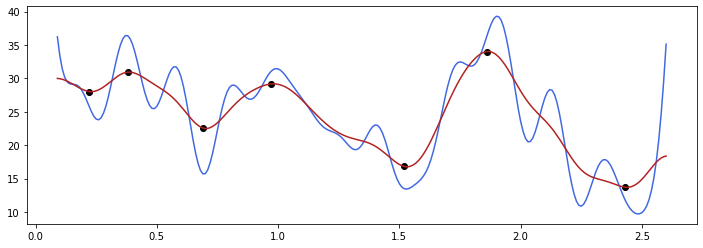

In [16]:
# random choice
i = np.random.choice(len(cores))
print("i = {}".format(i))
#i = 432

# step detection
core = cores[i]
t = core[:,0]
I = core[:,1]
Is, ids_step, dI = steps_detection(I, ws=1, n_iters=64)

# plot
plt.figure(figsize=(12,4))
plt.plot(t, I, '-', color='royalblue')
plt.plot(t[ids_step], Is[ids_step], 'ko')
plt.plot(t, Is, '-', color='firebrick')
plt.show()

100%|██████████| 28562/28562 [02:57<00:00, 160.72it/s]


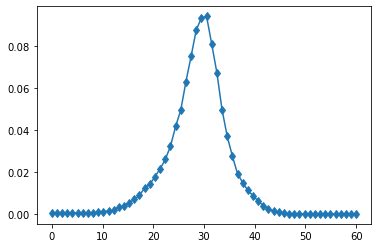

In [17]:
xlims = (0.0, 60.0)
nbins = 60
N = 2048

# make global distribution
x = np.linspace(xlims[0], xlims[1], nbins)
h = np.zeros(nbins)
#for i in tqdm(np.random.choice(len(cores), N)):
for i in tqdm(range(len(cores))):
    # step detection
    core = cores[i]
    t = core[:,0]
    I = core[:,1]
    Is, ids_step, dI = steps_detection(I, ws=1, n_iters=64)
    
    # make histogram
    hi, _ = np.histogram(Is[ids_step], range=xlims, bins=nbins)
    h = h + hi / (np.sum(hi) + 1e-6)
    
# normalize
h = h / np.sum(h)

# plot
plt.figure()
plt.plot(x,h,'d-')
plt.show()

In [18]:
def levels_probabilites(x, popt_l):
    z_l = []
    for i in range(len(popt_l)):
        popt = popt_l[i]
        z_l.append(tsp.fits.gauss(x, popt[0], popt[1], popt[2]))
    
    return np.stack(z_l, axis=1)

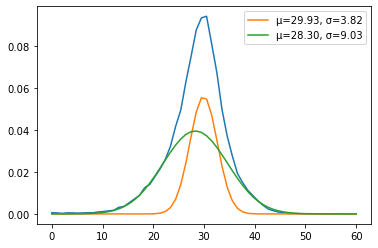

In [19]:
from scipy.optimize import curve_fit

def gauss(x, A, mu, sigma):
    return np.abs(A) * np.exp(-np.square((x - mu))/np.square(sigma))

def multi_gauss(x, *p):
    y = np.zeros(x.shape)
    for k in range(int(len(p) / 3)):
        y += gauss(x, p[3*k], p[3*k+1], p[3*k+2])

    return y

guess = np.array(
    [0.5, 25.0, 20.0,
     0.5, 40.0, 20.0]
)
popt, pcov = curve_fit(multi_gauss, x.astype(np.float64), h.astype(np.float64), p0=guess.astype(np.float64))
popt_l = [popt[3*k:3*(k+1)] for k in range(2)]

plt.figure()
plt.plot(x,h)
for i in range(len(popt_l)):
    popt = popt_l[i]
    z = tsp.fits.gauss(x, popt[0], popt[1], popt[2])
    plt.plot(x,z,label="μ={:.2f}, σ={:.2f}".format(popt[1], popt[2]))
plt.legend(loc='best')
plt.show()

i = 14362


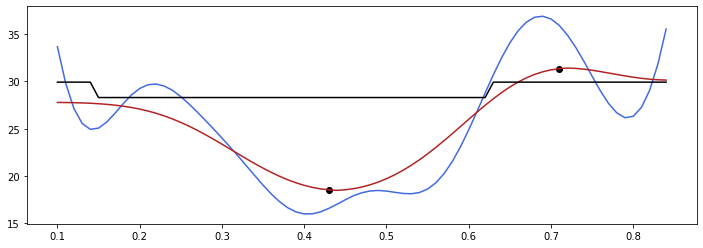

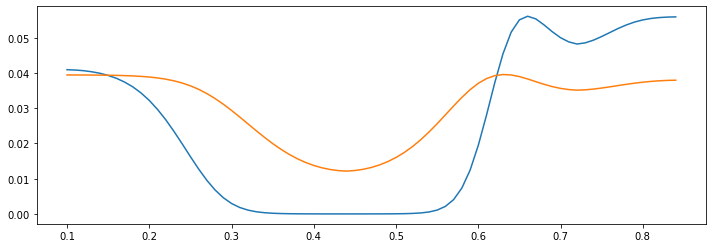

In [20]:
# parameters
a_thr = 0.5

# random choice
i = np.random.choice(len(cores))
print("i = {}".format(i))
#i = 4519

# step detection
core = cores[i]
t = core[:,0]
I = core[:,1]
Is, ids_step, dI = steps_detection(I, ws=1, n_iters=64)

# probability
P = levels_probabilites(Is, popt_l)

# levels detection
ids_lvl = np.argmax(P, axis=1)
Il = np.array([popt[1] for popt in popt_l])[ids_lvl]

# plot
plt.figure(figsize=(12,4))
plt.plot(t, I, '-', color='royalblue')
plt.plot(t[ids_step], Is[ids_step], 'ko')
plt.plot(t, Is, '-', color='firebrick')
plt.plot(t, Il, '-', color='black')
plt.show()

plt.figure(figsize=(12,4))
for i in range(2):
    plt.plot(t, P[:,i])
    #p_thr = np.abs(popt_l[i][0])*a_thr
    #plt.plot([t[0], t[-1]], [p_thr, p_thr], 'k--')
#plt.plot(t, np.abs(np.diff(P, axis=1)))
plt.show()

In [21]:
levels = []
for i in tqdm(range(len(cores))):
    # step detection
    core = cores[i]
    t = core[:,0]
    I = core[:,1]
    Is, ids_step, dI = steps_detection(I, ws=1, n_iters=64)

    # probability
    P = levels_probabilites(Is, popt_l)

    # levels detection
    ids_lvl = np.argmax(P, axis=1)
    levels.append(ids_lvl)

100%|██████████| 28562/28562 [02:59<00:00, 158.99it/s]


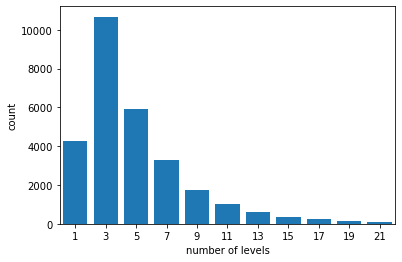

In [22]:
# count levels
c_lvls = np.array([np.sum(np.abs(np.diff(ids_lvl)))+(1-ids_lvl[0])+(1-ids_lvl[-1]) for ids_lvl in levels])
h = np.bincount(c_lvls)[::2]
#h = h / np.sum(h)

# figure
plt.figure()
plt.bar(np.arange(h.shape[0]), h)
plt.xticks(np.arange(h.shape[0]), 2*np.arange(h.shape[0])+1)
plt.xlim(-0.5, 10.5)
plt.ylabel('count')
plt.xlabel('number of levels')
plt.show()

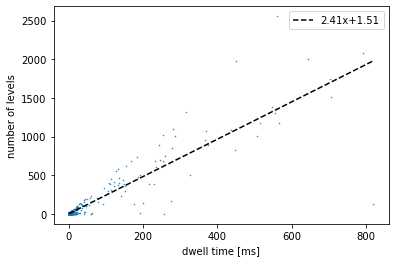

2.41 levels per ms


In [23]:
# correlate number of levels with event duration
dt = np.diff(cores[0][:,0])[0]
l_lvls = np.array([ids_lvl.shape[0]*dt for ids_lvl in levels])

# linear fit
a, b = np.polyfit(l_lvls, c_lvls, 1)
x = np.linspace(np.min(l_lvls), np.max(l_lvls))
y = a*x + b

# plot
plt.figure()
plt.plot(l_lvls, c_lvls, '.', ms=1.0)
plt.plot(x, y, 'k--', label='{:.2f}x+{:.2f}'.format(a,b))
plt.legend(loc='best')
plt.xlabel('dwell time [ms]')
plt.ylabel('number of levels')
plt.show()

print("{:.2f} levels per ms".format(a))

In [24]:
# parameters
n_lvls_sel = 7

# extract currents and dwell times of levels
Ir_lvls = [[] for k in range(n_lvls_sel-2)]
tr_lvls = [[] for k in range(n_lvls_sel-2)]
for i in tqdm(np.where((c_lvls+1) == n_lvls_sel)[0]):
    ids_lvl = levels[i]
    ids_lvl

    # find levels ranges
    rng_high = tsp.signals.find_continuous_segments(np.where(ids_lvl > 0.5)[0])
    rng_low = tsp.signals.find_continuous_segments(np.where(ids_lvl < 0.5)[0])

    # filter end levels and get interweaved levels
    rng_high = np.array([rng for rng in rng_high if (rng[0]!=0) and (rng[1]!=ids_lvl.shape[0]-1)])
    rngs = interweave(rng_low, rng_high)

    # extract currents and dwell times
    for k in range(len(rngs)):
        rng = rngs[k]
        Ir = cores[i][rng[0]:rng[1]+1,1]
        tr = cores[i][rng[1],0]-cores[i][rng[0],0]

        Ir_lvls[k].append(Ir)
        tr_lvls[k].append(tr)
        
# pack data
Ir_lvls = [np.array([np.mean(Ir) for Ir in Ir_l]) for Ir_l in Ir_lvls]
tr_lvls = [np.array(tr_l) for tr_l in tr_lvls]

100%|██████████| 3269/3269 [00:00<00:00, 14290.56it/s]


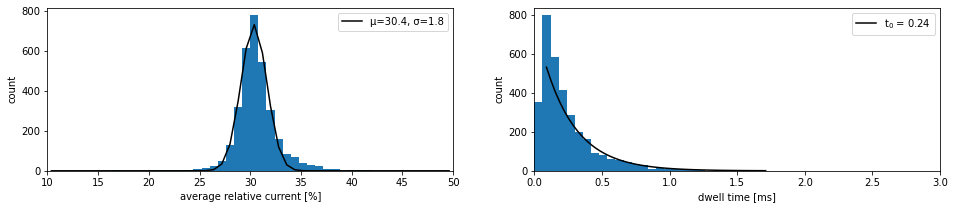

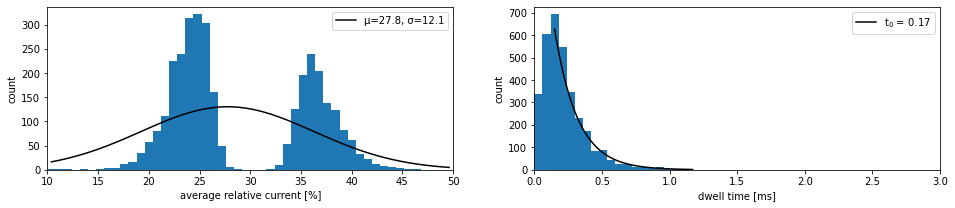

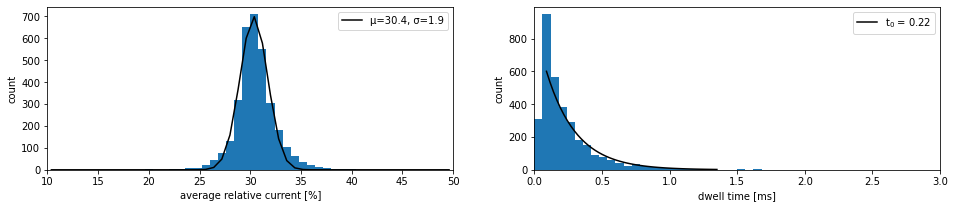

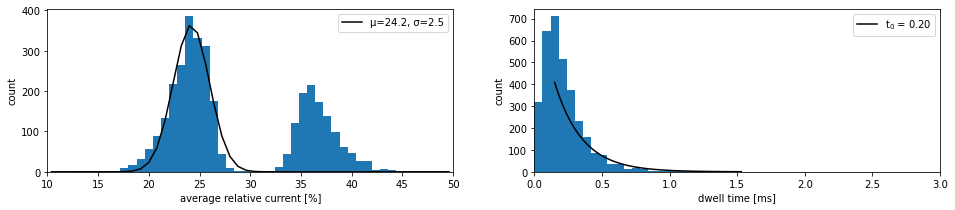

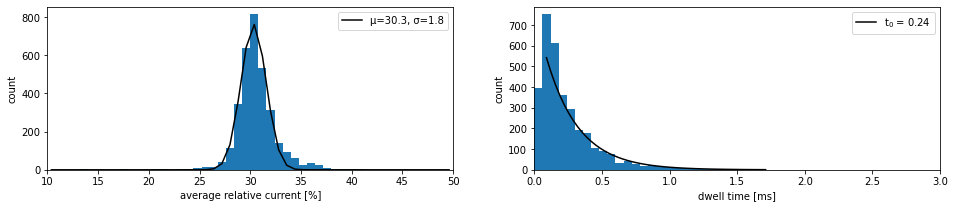

In [25]:
# !!! DO NOT USE !!!
# parameters
xlims = (10.0, 50.0)
xlims_t = (0.0, 3.0)
bins = 50
bins_t = 50

# plots
for k in range(len(Ir_lvls)):
    # gaussian fit
    h, Ih = np.histogram(Ir_lvls[k], range=xlims, bins=bins)
    Ih = 0.5*(Ih[:-1] + Ih[1:])

    z, popt = tsp.fits.multi_gauss_dist_fit(Ih, h)
    
    # plot
    plt.figure(figsize=(16,3))
    plt.subplot(121)
    plt.hist(Ir_lvls[k], range=xlims, bins=bins)
    plt.plot(Ih, z, 'k-', label='μ={:.1f}, σ={:.1f}'.format(popt[1], popt[2]))
    plt.xlim(xlims)
    plt.legend(loc='best')
    plt.xlabel('average relative current [%]')
    plt.ylabel('count')
    
    # dwell time fit
    h, dwt = np.histogram(tr_lvls[k], range=xlims_t, bins=bins_t)
    #h = h / np.sum(h)
    dwt = 0.5*(dwt[:-1] + dwt[1:])

    i0, i1 = np.argmax(h), np.argmin(h)
    xv = dwt[i0:i1]
    yv = np.log(h[i0:i1])
    a,b = np.polyfit(xv, yv, 1)

    x = np.linspace(dwt[i0], dwt[i1])
    y = np.exp(a * x + b)
    
    # plot
    plt.subplot(122)
    plt.hist(tr_lvls[k], range=xlims_t, bins=bins_t)
    plt.plot(x,y, 'k-', label='t$_0$ = {:.2f}'.format(-1.0/a))
    plt.xlim(0.0, 3.0)
    plt.legend(loc='best')
    plt.xlabel('dwell time [ms]')
    plt.ylabel('count')
    plt.show()